# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sb
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [4]:
profile.id.nunique()

17000

In [5]:
profile.groupby(['gender']).describe()[['income','age']]

income                                                         \
         count          mean           std      min      25%      50%   
gender                                                                  
F       6129.0  71306.412139  22338.353773  30000.0  54000.0  71000.0   
M       8484.0  61194.601603  20069.517615  30000.0  45000.0  59000.0   
O        212.0  63287.735849  18938.594726  30000.0  51000.0  62000.0   

                              age                                          \
            75%       max   count       mean        std   min   25%   50%   
gender                                                                      
F       88000.0  120000.0  6129.0  57.544950  16.883315  18.0  48.0  58.0   
M       73000.0  120000.0  8484.0  52.116690  17.413894  18.0  39.0  53.0   
O       79250.0  100000.0   212.0  54.400943  16.244710  20.0  43.0  55.0   

                     
         75%    max  
gender               
F       69.0  101.0  
M       65.0  100.0  
O       66.0  100.0

In [6]:
def generation(profile=profile):
    '''
    '''
    bin_edges = [10,20,30,40,50,60,70,80,90,100,110,120]
    bin_names = ['10s','20s','30s','40s','50s','60s','70s','80s','90s','100s','110s']
    generation = pd.cut(profile['age'], bin_edges, labels=bin_names)
    
    return generation.value_counts().plot(kind='bar');    

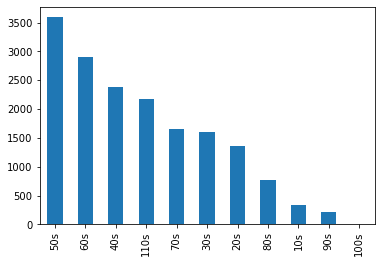

In [7]:
generation();

In [8]:
customer_118 = profile.query('age=="118"')
customer_118

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [9]:
customer_118.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

> numbers of 118 years old is 2175 that is the same numbers as null. "118" represents null
> by ML, 118 years old may be guessed.

In [10]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [11]:
transcript.query('event =="transaction"')

,person,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [12]:
transaction = pd.DataFrame(transcript.value.tolist())
transaction

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN


In [13]:
transaction['offer id'].combine_first(transaction['offer_id'])
transaction

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...
306529,NaN,1.59,NaN,NaN
306530,NaN,9.53,NaN,NaN
306531,NaN,3.61,NaN,NaN
306532,NaN,3.53,NaN,NaN


In [14]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   offer id  134002 non-null  object 
 1   amount    138953 non-null  float64
 2   offer_id  33579 non-null   object 
 3   reward    33579 non-null   float64
dtypes: float64(2), object(2)
memory usage: 9.4+ MB


In [15]:
transaction.amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [16]:
transaction.reward.value_counts()

5.0     12070
2.0      9334
10.0     7019
3.0      5156
Name: reward, dtype: int64

In [17]:
transcript.groupby(['event']).count()['value']

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: value, dtype: int64

In [18]:
profile.rename(columns={'id':'person'}, inplace=True)
profile.head(1)

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN


In [19]:
df = pd.merge(transcript, profile, on='person')
df

,person,event,value,time,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,F,75,20170509,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,F,75,20170509,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,F,75,20170509,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,F,75,20170509,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,F,75,20170509,100000.0
...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,None,118,20170926,NaN
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},594,None,118,20170926,NaN
306531,3045af4e98794a04a5542d3eac939b1f,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,20161020,78000.0
306532,3045af4e98794a04a5542d3eac939b1f,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},576,F,58,20161020,78000.0


In [20]:
df = pd.concat([df.drop('value', axis=1), pd.DataFrame(df['value'].tolist())],axis=1)
df.head()

,person,event,time,gender,age,became_member_on,income,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,F,75,20170509,100000.0,NaN,19.89,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,F,75,20170509,100000.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,F,75,20170509,100000.0,NaN,17.78,NaN,NaN


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   person            306534 non-null  object 
 1   event             306534 non-null  object 
 2   time              306534 non-null  int64  
 3   gender            272762 non-null  object 
 4   age               306534 non-null  int64  
 5   became_member_on  306534 non-null  int64  
 6   income            272762 non-null  float64
 7   offer id          134002 non-null  object 
 8   amount            138953 non-null  float64
 9   offer_id          33579 non-null   object 
 10  reward            33579 non-null   float64
dtypes: float64(3), int64(3), object(5)
memory usage: 28.1+ MB


In [22]:
df.head()

,person,event,time,gender,age,became_member_on,income,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,F,75,20170509,100000.0,NaN,19.89,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,F,75,20170509,100000.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,F,75,20170509,100000.0,NaN,17.78,NaN,NaN


In [23]:
df.person.nunique()

17000

In [24]:
df.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [40]:
df_118 = df.query('age == "118"')
df_118.person.nunique()

2175

In [42]:
df_118

,person,event,time,gender,age,became_member_on,income,offer id,amount,offer_id,reward
18,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,118,20170804,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
19,a03223e636434f42ac4c3df47e8bac43,offer viewed,6,NaN,118,20170804,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
20,a03223e636434f42ac4c3df47e8bac43,transaction,234,NaN,118,20170804,NaN,NaN,1.09,NaN,NaN
21,a03223e636434f42ac4c3df47e8bac43,transaction,264,NaN,118,20170804,NaN,NaN,3.50,NaN,NaN
22,a03223e636434f42ac4c3df47e8bac43,offer received,336,NaN,118,20170804,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
306527,ebae5093b436466c9fbd097cb7434023,transaction,660,NaN,118,20171203,NaN,NaN,12.64,NaN,NaN
306528,ebae5093b436466c9fbd097cb7434023,offer completed,660,NaN,118,20171203,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer received,576,NaN,118,20170926,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer viewed,594,NaN,118,20170926,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [53]:
df_118.groupby(['person','event']).sum()[['amount','reward']].sort_values(by='amount', ascending=False)

amount  reward
person                           event                          
2afcff4b5f4c42fc98b0280a0c8febc9 transaction      165.68     0.0
e93fb1a740ef4f6fa8f98d7c82492ad0 transaction      164.14     0.0
5a609dc56d1c4f6d848040b23ca6c806 transaction      158.38     0.0
0c55f7afe6a44b859a2344af100ec3f3 transaction      153.76     0.0
c4137a37c33446f2a22f59282865f6c5 transaction      150.94     0.0
...                                                  ...     ...
640ba8b8068043abb9c6778f8c671950 offer received     0.00     0.0
                                 offer completed    0.00     3.0
63e6ddd860d74724af5f476f8a3882ab offer viewed       0.00     0.0
                                 offer received     0.00     0.0
7ecfc592171f4844bdc05bdbb48d3847 offer received     0.00     0.0

[7207 rows x 2 columns]

In [48]:
df_118.groupby(['event']).count()['person']

event
offer completed     1135
offer received      9776
offer viewed        7865
transaction        14996
Name: person, dtype: int64

In [26]:
df_transaction = df.query('event == "transaction" & age !="118"')
df_transaction.head()

,person,event,time,gender,age,became_member_on,income,offer id,amount,offer_id,reward
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,F,75,20170509,100000.0,NaN,19.89,NaN,NaN
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,F,75,20170509,100000.0,NaN,17.78,NaN,NaN
7,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,F,75,20170509,100000.0,NaN,19.67,NaN,NaN
8,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,F,75,20170509,100000.0,NaN,29.72,NaN,NaN
9,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,F,75,20170509,100000.0,NaN,23.93,NaN,NaN


In [27]:
df_transaction.person.nunique()

14492

In [28]:
df_transaction.groupby(['person', 'gender','age','income']).sum()['amount'].sort_values(ascending=False)

person                            gender  age  income  
3c8d541112a74af99e88abbd0692f00e  M       77   97000.0     1608.69
f1d65ae63f174b8f80fa063adcaa63b7  M       32   64000.0     1365.66
ae6f43089b674728a50b8727252d3305  F       36   71000.0     1327.74
626df8678e2a4953b9098246418c9cfa  M       53   103000.0    1321.42
73afdeca19e349b98f09e928644610f8  M       50   86000.0     1319.97
                                                            ...   
0d3451dbd862480caf1f408154c18887  M       24   41000.0        0.29
74565e746984484d9600d596980fda12  M       39   57000.0        0.28
49c4a0965ad04077bac189d20a88ec4e  M       79   54000.0        0.23
ca5815021d3c42e2bef68f023a7764d0  M       42   33000.0        0.17
b90505ef4a754b139d54db583ee424ac  M       20   33000.0        0.15
Name: amount, Length: 14492, dtype: float64

In [29]:
df_transaction.groupby('gender').mean()

,time,age,became_member_on,income,amount,reward
gender,,,,,,
F,380.860030,55.637986,2.016480e+07,66813.960552,17.490077,NaN
M,381.727313,50.725650,2.016314e+07,58491.317966,11.606600,NaN
O,374.516564,52.906794,2.016551e+07,61039.865244,14.798731,NaN


In [30]:
df_offer = df.query('event != "transaction" & age !="118"')
df_offer.head()

,person,event,time,gender,age,became_member_on,income,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,F,75,20170509,100000.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
5,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,F,75,20170509,100000.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
6,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,F,75,20170509,100000.0,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN


In [31]:
df_offer.person.nunique()

14820

In [32]:
df_offer.groupby(['event','gender']).count()

person   time    age  became_member_on  income  \
event           gender                                                   
offer completed F        15477  15477  15477             15477   15477   
                M        16466  16466  16466             16466   16466   
                O          501    501    501               501     501   
offer received  F        27456  27456  27456             27456   27456   
                M        38129  38129  38129             38129   38129   
                O          916    916    916               916     916   
offer viewed    F        20786  20786  20786             20786   20786   
                M        28301  28301  28301             28301   28301   
                O          773    773    773               773     773   

                        offer id  amount  offer_id  reward  
event           gender                                      
offer completed F              0       0     15477   15477  
                M              0       0     16466   16466  
                O              0       0       501     501  
offer received  F          27456       0         0       0  
                M          38129       0         0       0  
                O            916       0         0       0  
offer viewed    F          20786       0         0       0  
                M          28301       0         0       0  
                O            773       0         0       0

In [33]:
pd.to_datetime(df['became_member_on'])

0        1970-01-01 00:00:00.020170509
1        1970-01-01 00:00:00.020170509
2        1970-01-01 00:00:00.020170509
3        1970-01-01 00:00:00.020170509
4        1970-01-01 00:00:00.020170509
                      ...             
306529   1970-01-01 00:00:00.020170926
306530   1970-01-01 00:00:00.020170926
306531   1970-01-01 00:00:00.020161020
306532   1970-01-01 00:00:00.020161020
306533   1970-01-01 00:00:00.020170801
Name: became_member_on, Length: 306534, dtype: datetime64[ns]

In [34]:
pd.to_datetime('20161020')

Timestamp('2016-10-20 00:00:00')

In [35]:
df.to_csv('df.csv', index=False)

In [36]:
df = pd.read_csv('df.csv')
df

,person,event,time,gender,age,became_member_on,income,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,F,75,20170509,100000.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,F,75,20170509,100000.0,NaN,19.89,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,F,75,20170509,100000.0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,F,75,20170509,100000.0,NaN,17.78,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer received,576,NaN,118,20170926,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer viewed,594,NaN,118,20170926,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
306531,3045af4e98794a04a5542d3eac939b1f,offer received,576,F,58,20161020,78000.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
306532,3045af4e98794a04a5542d3eac939b1f,offer viewed,576,F,58,20161020,78000.0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [37]:
df.person.nunique()

17000

In [38]:
df_118 = df.query('age == "118"')
df_118

,person,event,time,gender,age,became_member_on,income,offer id,amount,offer_id,reward
18,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,118,20170804,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
19,a03223e636434f42ac4c3df47e8bac43,offer viewed,6,NaN,118,20170804,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
20,a03223e636434f42ac4c3df47e8bac43,transaction,234,NaN,118,20170804,NaN,NaN,1.09,NaN,NaN
21,a03223e636434f42ac4c3df47e8bac43,transaction,264,NaN,118,20170804,NaN,NaN,3.50,NaN,NaN
22,a03223e636434f42ac4c3df47e8bac43,offer received,336,NaN,118,20170804,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
306527,ebae5093b436466c9fbd097cb7434023,transaction,660,NaN,118,20171203,NaN,NaN,12.64,NaN,NaN
306528,ebae5093b436466c9fbd097cb7434023,offer completed,660,NaN,118,20171203,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0
306529,912b9f623b9e4b4eb99b6dc919f09a93,offer received,576,NaN,118,20170926,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
306530,912b9f623b9e4b4eb99b6dc919f09a93,offer viewed,594,NaN,118,20170926,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [39]:
df_118.groupby(['event']).count().sort_values(by= 'value', ascending=False)

KeyError: 'value'

In [ ]:
df.groupby(['event']).count().sort_values(by= 'value', ascending=False)